# Example of usage ImageAdaptiveTresholding transformer

## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [2]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [3]:
import sys
import os

if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
# install from PYPI using secret
%pip install spark-ocr==$version --user --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [4]:
#or install from local path
#%pip install ../../python/dist/spark-ocr-1.8.0rc3.spark24.tar.gz

Processing /Users/nmelnik/IdeaProjects/spark-ocr/python/dist/spark-ocr-1.8.0rc3.spark24.tar.gz
  Created wheel for spark-ocr: filename=spark_ocr-1.8.0rc3.spark24-py3-none-any.whl size=7793781 sha256=336a60b4df4c0058dbf0d98284920aee78d9efb99ee5bbcc8fb1d3604aaf13d4
  Stored in directory: /Users/nmelnik/Library/Caches/pip/wheels/7c/68/80/4dece6ff365da94b988e51cb5bcf0570c341b4d2e7e6d0875b
Successfully built spark-ocr
  Attempting uninstall: spark-ocr
    Found existing installation: spark-ocr 1.8.0rc3.spark24
    Uninstalling spark-ocr-1.8.0rc3.spark24:
      Successfully uninstalled spark-ocr-1.8.0rc3.spark24
Note: you may need to restart the kernel to use updated packages.


## Initialization of spark session

In [3]:
from pyspark.sql import SparkSession
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

--- Logging error ---
Traceback (most recent call last):
  File "/Users/nmelnik/.pyenv/versions/3.7.9/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/Users/nmelnik/.pyenv/versions/3.7.9/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/Users/nmelnik/.pyenv/versions/3.7.9/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/Users/nmelnik/.pyenv/versions/3.7.9/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/Users/nmelnik/.pyenv/versions/3.7.9/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/nmelnik/.pyenv/versions/3.7.9/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.

## Import OCR transformers

In [4]:
from pyspark.ml import PipelineModel

from sparkocr.transformers import *
from sparkocr.utils import display_image

## Define OCR transformers and pipeline

In [5]:
binary_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image")

adaptive_thresholding = ImageAdaptiveThresholding() \
    .setInputCol("image") \
    .setOutputCol("corrected_image") \
    .setBlockSize(35) \
    .setOffset(80) \
    .setKeepInput(True)

pipeline = PipelineModel(stages=[
    binary_to_image,
    adaptive_thresholding
])

## Read PDF document as binary file

In [6]:
import pkg_resources
image_example = "data/images/text_with_noise.png"
image_example_df = spark.read.format("binaryFile").load(image_example).cache()

## Run OCR pipelines

In [7]:
result = pipeline.transform(image_example_df).cache()

## Display results

Image:
        origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/images/text_with_noise.png 
        width: 1095
        height: 134
        mode: 10


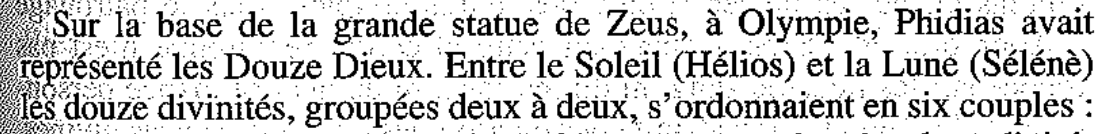

Image:
        origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/images/text_with_noise.png 
        width: 1095
        height: 134
        mode: 12


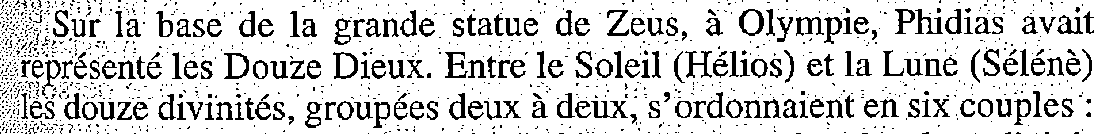

In [8]:
for r in result.select("image", "corrected_image").collect():
    display_image(r.image)
    display_image(r.corrected_image)